## **Catégorisez automatiquement des questions**

### partie 3/8 : Prédiction de tags, approche non-supervisée

#### <br> Proposition de mots clés, de type LDA avec visualisation en 2D des topics

<br>


## Importation des librairies, réglages


In [1]:
import os, sys, random
import ast
# from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from pprint import pprint

# Visualisation
import matplotlib.pyplot as plt
# import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from PIL import Image

# NLP
from bs4 import BeautifulSoup
import re, string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Feature engineering
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import similarities
from gensim.models.ldamulticore import LdaMulticore

from sklearn.model_selection import GridSearchCV

print('\nPython version ' + sys.version)
print('pyLDAvis version ' + pyLDAvis.__version__)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
pyLDAvis version 3.4.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Fonctions


In [2]:
def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


def show_cloud(word_list):
    """
    Display a word cloud based on the provided list of words.

    Parameters:
    - word_list (list): A list of words to visualize in the word cloud.

    Returns:
    None
    """
    cloud = WordCloud(background_color='white',
                    stopwords=[],
                    max_words=50).generate(" ".join(word_list))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()


### import


In [3]:
train = pd.read_csv('./../data/cleaned_data/train_bow_uniques.csv', sep=',')
test = pd.read_csv('./../data/cleaned_data/test_bow_uniques.csv', sep=',')

quick_look(train)


shape : (42898, 8)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
0,2019-06-05 15:13:02,How to use memset while handling strings in C++?,I am from Python background and recently learn...,"['c++', 'initialization', 'c-strings', 'string...","['memset', 'handle', 'string']","['memset', 'handle', 'string', 'python', 'back...","['use', 'memset', 'handle', 'string']","['background', 'learn', 'function', 'memset', ..."
1,2018-10-31 12:35:02,How to correct spelling in google docs using k...,I would like to be able to replace a misspelle...,"['gmail', 'keyboard-shortcuts', 'google-docs',...","['correct', 'spell', 'google', 'doc', 'keyboar...","['correct', 'spell', 'google', 'doc', 'shortcu...","['correct', 'spelling', 'keyboard', 'shortcut']","['like', 'replace', 'word', 'recommend', 'corr..."
2,2020-09-19 10:40:23,live server vscode on another computer,I have 2 computers. when I open the project wi...,"['visual-studio-code', 'server', 'localhost', ...","['server', 'vscode', 'computer']","['server', 'vscode', 'computer', 'open', 'proj...","['server', 'vscode', 'computer']","['computer', 'open', 'project', 'server', 'url..."
3,2012-10-23 16:47:04,django ajax post 403 forbidden,using django 1.4 im getting a 403 error when i...,"['javascript', 'ajax', 'django', 'http-post', ...","['django', 'ajax', 'forbidden']","['django', 'ajax', 'get', 'error', 'try', 'pos...",['forbid'],"['django', 'error', 'try', 'post', 'javascript..."
4,2019-04-21 16:10:24,Listen to changes and reload container on code...,I am using docker-compose in visual studio 201...,"['angular', 'visual-studio', 'docker', 'docker...","['listen', 'change', 'reload', 'container', 'c...","['listen', 'change', 'reload', 'container', 'c...","['listen', 'change', 'reload', 'container', 'c...","['docker', 'compose', 'studio', 'window', 'run..."


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
42893,2017-02-23 11:34:31,Do we need clear MDC after HTTP request in Spring,According to this answer thread local variable...,"['java', 'spring', 'logging', 'log4j', 'logback']","['need', 'mdc', 'request', 'spring']","['need', 'mdc', 'request', 'spring', 'accord',...","['need', 'request']","['accord', 'answer', 'thread', 'variable', 'us..."
42894,2011-10-13 20:57:32,How to make i18n with Handlebars.js (mustache ...,I'm currently using Handlebars.js (associated ...,"['javascript', 'jquery', 'internationalization...","['make', 'i18n', 'handlebar', 'template']","['make', 'i18n', 'handlebar', 'template', 'ass...",['template'],"['associate', 'web', 'app', 'client', 'render'..."
42895,2012-09-06 00:16:46,How can I make R read my environmental variables?,I am running R on EC2 spot instances and I nee...,"['linux', 'r', 'ubuntu', 'amazon-ec2', 'enviro...","['make', 'read', 'variable']","['make', 'read', 'variable', 'run', 'spot', 'i...","['read', 'variable']","['run', 'spot', 'instance', 'need', 'terminate..."
42896,2021-03-23 03:50:50,How to prevent react-query from fetching initi...,I'm using react-query v3.13 to fetch data from...,"['javascript', 'reactjs', 'fetch', 'react-quer...","['prevent', 'query', 'fetch', 'enable']","['prevent', 'query', 'fetch', 'enable', 'data'...","['prevent', 'react', 'query', 'fetch', 'enable']","['react', 'query', 'fetch', 'datum', 'want', '..."
42897,2016-03-17 04:19:15,Inserting into table with an Identity column w...,I have a table A_tbl in my database. I have cr...,"['sql', 'sql-server', 'database', 'ssms', 'dat...","['insert', 'table', 'identity', 'column', 'rep...","['insert', 'table', 'identity', 'column', 'rep...","['insert', 'table', 'column', 'replication', '...","['table', 'database', 'create', 'trigger', 'ca..."


uniques :


CreationDate    42893
title           42897
body            42898
all_tags        41513
title_nltk      42171
body_nltk       42898
title_spacy     37346
body_spacy      42891
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
CreationDate,CreationDate,0,42898,0.0,object
title,title,0,42898,0.0,object
body,body,0,42898,0.0,object
all_tags,all_tags,0,42898,0.0,object
title_nltk,title_nltk,0,42898,0.0,object
body_nltk,body_nltk,0,42898,0.0,object
title_spacy,title_spacy,0,42898,0.0,object
body_spacy,body_spacy,0,42898,0.0,object


In [4]:
# Tt semble OK, sauf les types : le fait d'exporter nos données a converti nos listes de tokens en str

def turn_str_back_into_list(df):
    """Correct the type change due to .csv export"""

    df['title_nltk'] = df['title_nltk'].apply(ast.literal_eval)
    df['body_nltk'] = df['body_nltk'].apply(ast.literal_eval)
    df['title_spacy'] = df['title_spacy'].apply(ast.literal_eval)
    df['body_spacy'] = df['body_spacy'].apply(ast.literal_eval)


turn_str_back_into_list(train)
turn_str_back_into_list(test)


In [5]:
# Vérif
train[['title_nltk', 'body_nltk', 'title_spacy', 'body_spacy']].map(len).describe()

# OK, pas de liste vide (min = 1)


,title_nltk,body_nltk,title_spacy,body_spacy
count,42898.000000,42898.000000,42898.000000,42898.000000
mean,4.409903,39.608653,3.311413,29.030444
std,1.732934,27.997950,1.619366,20.274162
min,1.000000,2.000000,1.000000,1.000000
25%,3.000000,21.000000,2.000000,16.000000
50%,4.000000,32.000000,3.000000,24.000000
75%,5.000000,50.000000,4.000000,37.000000
max,14.000000,368.000000,12.000000,307.000000


In [6]:
# quick_look(test)


In [7]:
test[['title_nltk', 'body_nltk', 'title_spacy', 'body_spacy']].map(len).describe()

# OK


,title_nltk,body_nltk,title_spacy,body_spacy
count,4767.000000,4767.000000,4767.000000,4767.000000
mean,4.395427,39.790854,3.284665,29.205160
std,1.716085,27.418228,1.620959,19.973006
min,1.000000,3.000000,1.000000,1.000000
25%,3.000000,21.000000,2.000000,16.000000
50%,4.000000,32.000000,3.000000,24.000000
75%,5.000000,51.000000,4.000000,37.000000
max,13.000000,268.000000,12.000000,194.000000


In [8]:
# Utile si nos inputs st sous forme de string
# mais il semble qu'on va plutôt conserver la liste de tokens au final

def fix_false_null_values(df):
    """
    Replace NaN values in specified columns with the string 'null'.
    ! USE ONLY AFTER VERIFYING that the NaN values are all the "null" string
    """
    df.loc[(df['title_nltk'].isna()), 'title_nltk'] = 'null'
    df.loc[(df['title_spacy'].isna()), 'title_spacy'] = 'null'


# fix_false_null_values(train)
# fix_false_null_values(test)

# Check for null values in the entire DataFrame
# null_values = train[train.isnull().any(axis=1)]

# Print the rows with null values
# print(null_values)


In [9]:
# quick_look(train)
# quick_look(test)


In [10]:
index = [4532, 8280, 12992, 14957, 22934, 24964, 25950]

display(train.loc[train.index.isin(index), :])

# OK


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
4532,2013-10-23 22:23:31,How to change type of id in Microsoft.AspNet.I...,"(ASP.NET MVC 5, EF6, VS2013)\nI'm trying to fi...","['asp.net-mvc', 'entity-framework', 'asp.net-m...","[change, type, aspnet, identity, entityframewo...","[change, type, aspnet, identity, entityframewo...","[change, type, identity]","[try, figure, change, type, field, string, int..."
8280,2014-06-20 18:46:09,"Bootstrap form input: prevent submit, but allo...",I've got the following problem: \nI use bootst...,"['javascript', 'jquery', 'html', 'forms', 'twi...","[bootstrap, form, input, submit, allow, checking]","[bootstrap, form, input, submit, allow, check,...","[bootstrap, form, input, prevent, submit, allo...","[problem, use, bootstrap, form, input, user, p..."
12992,2017-08-21 19:46:31,PySpark: org.apache.spark.sql.AnalysisExceptio...,"I'm trying to load Parquet data into PySpark, ...","['python', 'apache-spark', 'pyspark', 'apache-...","[pyspark, apache, spark, attribute, name, cont...","[pyspark, apache, spark, attribute, name, cont...","[org.apache.spark.sql, analysisexception, cont...","[try, load, datum, column, space, aliase, erro..."
14957,2018-08-08 12:58:34,How to break ForEach Loop in TypeScript,"I have a the below code, on which i am unable ...","['javascript', 'angular', 'typescript', 'forea...","[break, loop, typescript]","[break, loop, typescript, code, condition, fun...",[break],"[code, break, loop, condition, function, let, ..."
22934,2014-11-26 18:26:05,Python: Creating a 2D histogram from a numpy m...,"I'm new to python.\nI have a numpy matrix, of ...","['python', 'numpy', 'matrix', 'matplotlib', 'h...","[python, create, histogram, matrix]","[python, create, histogram, matrix, dimension,...","[python, create, histogram, matrix]","[python, matrix, dimension, value, range, want..."
24964,2011-11-28 02:41:21,SSRS line chart not connecting data points,I've looked high and low and can't seem to fin...,"['join', 'reporting-services', 'graph', 'chart...","[line, chart, connect, data, point]","[line, chart, connect, data, point, look, seem...","[line, chart, connect, datum, point]","[look, find, answer, appear, issue, think, lin..."
25950,2014-08-21 15:58:49,GS1 barcode parsing,We need to parse the GS1 datamatrix barcode wh...,"['parsing', 'barcode', 'datamatrix', 'gs1-data...","[barcode, parse]","[barcode, parse, need, provide, party, know, l...","[barcode, parse]","[need, parse, barcode, provide, party, know, u..."


## LDA


### lda_test


In [11]:
# add random state
# add grid search cv
# add other score ? silhouette ? ...

def suggest_topics_using_LDA(df, feature, alea=42):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Set training parameters.
    num_topics = 10
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = gensim_dictionary[0]  # This is only to "load" the dictionary.
    id2word = gensim_dictionary.id2token

    model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every, random_state=alea)

    top_topics = model.top_topics(corpus, topn=20)

    # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
    # = umass if same topn (default 20)
    avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
    print('Average topic coherence: %.4f.' % avg_topic_coherence)

    # Compute Coherence Score (Umass)
    coherence_umass = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='u_mass')
    coherence_lda_umass = coherence_umass.get_coherence()
    print('u_mass Coherence Score: %.4f.' % coherence_lda_umass)

    # Compute Coherence Score (cv)
    coherence_cv = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_v')
    coherence_lda_cv = coherence_cv.get_coherence()
    print('c_v Coherence Score: %.4f.' % coherence_lda_cv)

    # Compute Coherence Score (npmi)
    coherence_npmi = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_npmi')
    coherence_lda_npmi = coherence_npmi.get_coherence()
    print('c_npmi Coherence Score: %.4f.' % coherence_lda_npmi)

    # Perplexity is not a coherence score but a measure of how well the model predicts a sample.
    # A lower perplexity indicates better model performance.
    perplexity = model.log_perplexity(corpus)
    print('Perplexity: %.4f.' % perplexity)

    # Visualize the topics
    vis_data = gensimvis.prepare(model, corpus, gensim_dictionary)
    display(pyLDAvis.display(vis_data))

    # Uncomment the next line if you want to save the plot to a file
    # pyLDAvis.save_html(vis_data, 'artifacts/lda_vis.html')

    pprint(top_topics)
    # to print all topics
    # pprint(model.print_topics())

    return model, corpus, gensim_dictionary

lda_test, corpus_test, dict_test = suggest_topics_using_LDA(train, 'title_nltk')


Average topic coherence: -8.5107.
u_mass Coherence Score: -8.5107.
c_v Coherence Score: 0.3175.
c_npmi Coherence Score: -0.0982.
Perplexity: -7.4233.


[([(0.07479696, 'error'),
   (0.060631543, 'get'),
   (0.034807947, 'set'),
   (0.029401656, 'run'),
   (0.026773216, 'app'),
   (0.026079139, 'window'),
   (0.023387205, 'fail'),
   (0.022578528, 'code'),
   (0.020871533, 'studio'),
   (0.020859843, 'server'),
   (0.01886585, 'project'),
   (0.01886144, 'application'),
   (0.016678695, 'build'),
   (0.015824936, 'check'),
   (0.014559541, 'version'),
   (0.014034186, 'support'),
   (0.0138767455, 'page'),
   (0.013625901, 'web'),
   (0.01352738, 'docker'),
   (0.013103543, 'google')],
  -4.341587363954438),
 ([(0.039501354, 'change'),
   (0.037288364, 'type'),
   (0.03659408, 'array'),
   (0.034919944, 'object'),
   (0.033268224, 'json'),
   (0.02981556, 'list'),
   (0.02748291, 'load'),
   (0.027029378, 'javascript'),
   (0.026415395, 'android'),
   (0.022704136, 'text'),
   (0.016915297, 'field'),
   (0.016828615, 'read'),
   (0.016645376, 'html'),
   (0.015956344, 'color'),
   (0.015425753, 'size'),
   (0.01535724, 'system'),
   (0

### outputs


In [12]:
print(len(corpus_test)) # = nb documents (questions)
print(len(dict_test), '\n') # = nb tokens uniques

# Get the Document-Topic Matrix
document_topic_matrix = lda_test.get_document_topics(corpus_test)

# Print the Document-Topic Matrix
for i, document_topics in enumerate(document_topic_matrix[:12]):
    print(f"Document {i + 1} Topics: {document_topics}")
print('\n')

# Get the Topic-Word Matrix
topic_word_matrix = lda_test.get_topics()

# Print the Topic-Word Matrix
for topic_id, topic_terms in enumerate(topic_word_matrix):
    term_weights = [(term_id, weight) for term_id, weight in enumerate(topic_terms)]
    terms_with_names = [(dict_test.id2token[term_id], weight) for term_id, weight in term_weights]
    print(f"Topic {topic_id + 1} Terms: {terms_with_names}")

print('\n')
# ordonné par importance décroissante
# ressemble + à une distribution multinomiale
pprint(lda_test.print_topics())


42898
5869 

Document 1 Topics: [(0, 0.050553575), (1, 0.06189909), (2, 0.070598036), (3, 0.056645826), (4, 0.06592149), (5, 0.07206973), (6, 0.17589553), (7, 0.1630406), (8, 0.20068167), (9, 0.08269447)]
Document 2 Topics: [(0, 0.22605576), (1, 0.05043026), (2, 0.05751746), (3, 0.04615034), (4, 0.05370739), (5, 0.058716472), (6, 0.14329955), (7, 0.07114833), (8, 0.16397478), (9, 0.12899965)]
Document 3 Topics: [(0, 0.050528087), (1, 0.061867878), (2, 0.07056247), (3, 0.056617267), (4, 0.06588826), (5, 0.07203341), (6, 0.10013937), (7, 0.16290297), (8, 0.2011669), (9, 0.15829341)]
Document 4 Topics: [(0, 0.05053059), (1, 0.061870944), (2, 0.14623594), (3, 0.05662008), (4, 0.065891534), (5, 0.22325957), (6, 0.100144334), (7, 0.08728916), (8, 0.12550096), (9, 0.08265691)]
Document 5 Topics: [(0, 0.038787805), (1, 0.105566695), (2, 0.054167166), (3, 0.101532765), (4, 0.1086654), (5, 0.055296335), (6, 0.1349618), (7, 0.12505919), (8, 0.2125146), (9, 0.0634483)]
Document 6 Topics: [(0, 0.05

### Hyperparametres alpha, eta


In [13]:
print('\n', f'alpha : {lda_test.alpha}')
print('\n', f'eta : {lda_test.eta}')

# alpha et eta sont des parametres de concentrations, tjs >0
# alpha décrit la concentration des ditributions dans la matrice document-topic,
# eta dans la matice topic-mots

# valeur proche de 0 = les distribs st proches des coins du simplex, la plupart ont des valeurs dominantes.
# proche de 1 = toutes sortes de distribs possibles (assez uniformement réparties ds le simplex)
# valeur > 1 : les distributions tendent à se concentrer vers le centre de simplex, la plupart ont
# des distributions étalées, assez uniformes.

# Ici,
# alpha proche de 1 signifie que la distribution des topics par document est relativement uniforme,
# des topics plus dominants émergent rarement.
# eta proche de 0 signifie au contraire que la distribution des mots par topic est plus concentrée,
# les topics peuvent être "résumés" par un plus petit groupe de mots dominants.

# Meme pour une lda test encore non optimisée, ces résultats ont du sens :
# les questions stacks overflow ont en effet des topics assez proches, il s'agit d'un site spécialisé.
# On n'y trouve pas vraiment de questions cuisine ou bricolage !
# Il est malgré tout possible d'y définir des topics bien caractérisés : par exemple
# la data science, le developpement web frontend, backend, le portage multiplateformes, les bases de données,
# etc...



 alpha : [0.6677012  0.81755036 0.9324447  0.74816644 0.8706776  0.9518824
 1.3232876  1.1534218  1.6583452  1.0922121 ]

 eta : [0.08275855 0.07997459 0.08390974 ... 0.07412108 0.07407492 0.07403066]


### wordcloud


Topic : 1


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


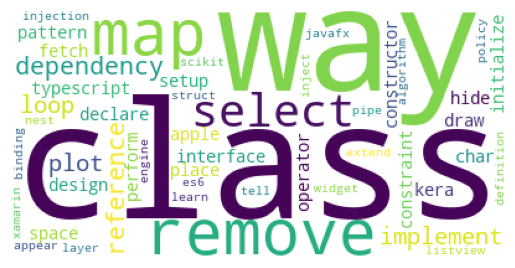

Topic : 2


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


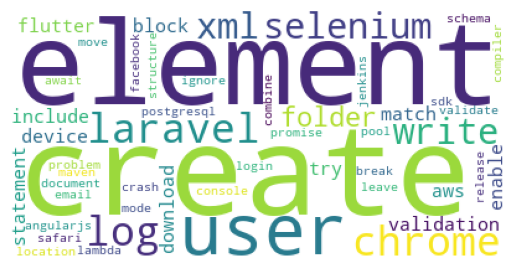

Topic : 3


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


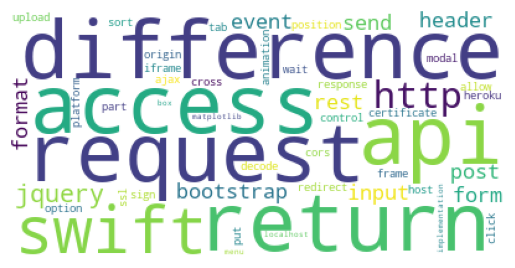

Topic : 4


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


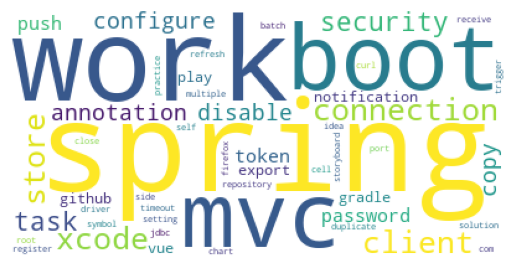

Topic : 5


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


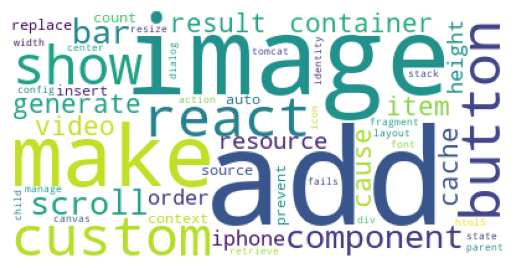

Topic : 6


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


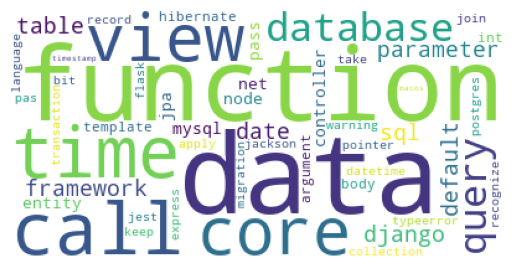

Topic : 7


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


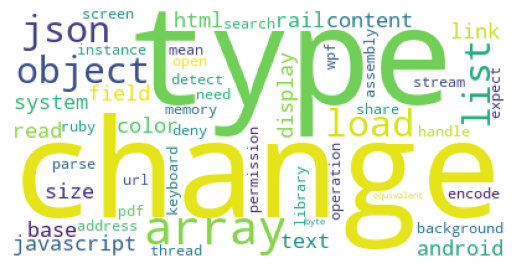

Topic : 8


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


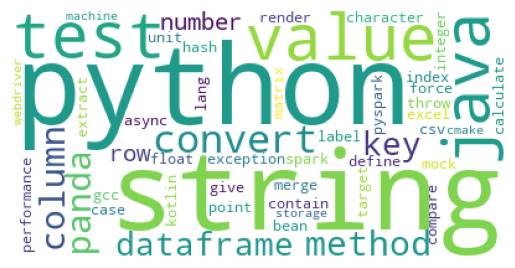

Topic : 9


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


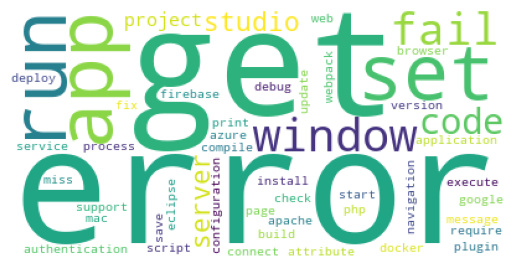

Topic : 10


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


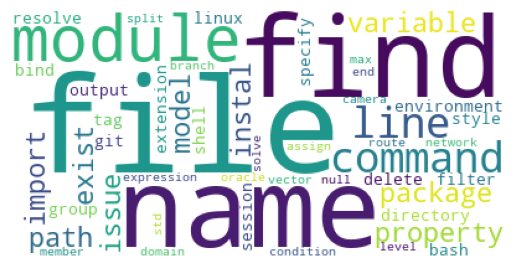

In [14]:
num_top_words = 50

# Extract topic terms
topics_terms = lda_test.print_topics(num_topics=-1, num_words=num_top_words)

# Parse the output to get a list of top words for each topic
top_words_per_topic = []
for topic_terms in topics_terms:
    topic_words = [word.split("*")[1].strip() for word in topic_terms[1].split(" + ")]
    top_words_per_topic.append(topic_words)

# Display or use the extracted top words
for i, top_words in enumerate(top_words_per_topic):
    print(f'Topic : {i + 1}')
    show_cloud(top_words)


### Une métrique pour évaluer la séparation / la similarité des topics


In [15]:
# Du point de vue metier, des topics tres proches peuvent etre consideres
# comme etant un seul topic. Il est + interessant d'avoir des topics bien differents les uns des autres.

# Thought about using clustering scores like silhouette, davies-bouldin, etc...
# but lda is different from clustering, it returns not 1 label, but a distribution of probabilities over topics.
# so it's not possible to use davies-bouldin or silhouette directly to check if the topics are well separated.
# Instead, we can use a metric that evaluates the overlap between topics, such as the Jaccard similarity

topn = 1000

def jaccard_similarity(topic1, topic2):
    set1 = set(topic1)
    set2 = set(topic2)
    return len(set1.intersection(set2)) / len(set1.union(set2))

# Example
topic1 = lda_test.show_topic(0, topn=topn)
topn_tokens_topic1 = [token for token, proba in topic1]

print(topic1)
print(len(topic1))
print(topn_tokens_topic1)

topic2 = lda_test.show_topic(1, topn=topn)
topn_tokens_topic2 = [token for token, proba in topic2]

print(topic2)
print(len(topic2))
print(topn_tokens_topic2)

print('Jaccard Similarity between Topics 0 and 1:', jaccard_similarity(topn_tokens_topic1, topn_tokens_topic2))

# Pour avoir une idée sur l'ensemble des topics
def average_jaccard_similarity(lda_model):
    num_topics = lda_model.num_topics
    total_similarity = 0.0
    pair_count = 0

    # Iterate over all pairs of topics
    for i in range(num_topics):
        for j in range(i + 1, num_topics):
            # Get the word distributions for the two topics
            topic1 = lda_model.show_topic(i, topn=topn)
            topn_tokens_topic1 = [token for token, proba in topic1]
            topic2 = lda_model.show_topic(j, topn=topn)
            topn_tokens_topic2 = [token for token, proba in topic2]

            # Calculate Jaccard similarity and update total_similarity
            similarity = jaccard_similarity(topn_tokens_topic1, topn_tokens_topic2)
            total_similarity += similarity
            pair_count += 1

    # Calculate the average Jaccard similarity
    average_similarity = total_similarity / pair_count
    return average_similarity

# Example
average_jaccard = average_jaccard_similarity(lda_test)
print('Average Jaccard Similarity between Topics:', average_jaccard)


[('class', 0.06737597), ('way', 0.056430094), ('remove', 0.03368802), ('map', 0.028085636), ('select', 0.023829194), ('dependency', 0.021766355), ('reference', 0.02097078), ('implement', 0.018758764), ('loop', 0.016508333), ('plot', 0.014510898), ('typescript', 0.014506913), ('space', 0.012193546), ('interface', 0.011839142), ('hide', 0.011373441), ('kera', 0.010939138), ('constructor', 0.0109230755), ('pattern', 0.0104529215), ('initialize', 0.010317057), ('setup', 0.010012351), ('fetch', 0.0096177645), ('constraint', 0.008989125), ('operator', 0.008626081), ('draw', 0.008036), ('design', 0.008006773), ('declare', 0.0077851475), ('char', 0.0075318036), ('place', 0.0073305406), ('perform', 0.0067365873), ('apple', 0.006668724), ('injection', 0.006512529), ('widget', 0.006229983), ('javafx', 0.0060705035), ('nest', 0.006048248), ('layer', 0.005970794), ('learn', 0.005928728), ('listview', 0.005891866), ('appear', 0.0057743564), ('scikit', 0.0057315137), ('xamarin', 0.0055543976), ('exte

Average Jaccard Similarity between Topics: 0.282306101609886


### Prediction


In [16]:
new_doc1 = "I have a python problem. I don't understand the difference between a slice and a copy."
new_doc2 = "I have a javascript problem. I don't understand the difference between a div and a span."
new_doc3 = "I like cookies."

# Preprocessing, identique à celui des autres docs

def preprocess_text(text):
    #Cleaning
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = text.lower().strip()

    # Tokenization
    try:
        tokens = nltk.word_tokenize(text)
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(" ".join(tokens))  # Apply RegexpTokenizer to the entire list

        # Remove punctuation (make sure, RegexpTokenizer should have done it already)
        tokens = [token for token in tokens if token not in string.punctuation]

    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    # Get part of speech for each token
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = []

    for token, pos_tag in pos_tags:
        # ! Uncommenting next line may crash the cell
        # print(f"Token: {token}, POS Tag: {pos_tag}")
        if pos_tag.startswith('V'):
            # On garde
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='v'))
            # Returns the input word unchanged if it cannot be found in WordNet.
        elif pos_tag.startswith('N'):
            # On garde
            try:
                lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='n'))
            except Exception as e:
                print(f"Error lemmatizing verb {token}: {e}")
        # Sinon on supprime

    # Read forbidden words (stopwords, too frequent, too rare) from the file
    with open('./../data/cleaned_data/forbidden_words.txt', 'r') as file:
        forbidden = [line.strip() for line in file]

    filtered_list = [token for token in lemmatized_tokens if token not in forbidden]

    # keep uniques
    seen_tokens = set()
    unique_tokens = []

    for token in filtered_list:
        if token not in seen_tokens:
            seen_tokens.add(token)
            if len(token) > 2:
                unique_tokens.append(token)

    return unique_tokens


def predict_topics(text):
    # Tokenize and preprocess the new document
    new_doc_tokens = preprocess_text(text)  # Use the same preprocess function used during training

    # Convert the new document to a bag-of-words representation using the dictionary
    new_doc_bow = dict_test.doc2bow(new_doc_tokens)

    # Infer topic distribution for the new document
    topic_distribution = lda_test.get_document_topics(new_doc_bow)

    # Print the inferred topic distribution
    print(f"Inferred Topic Distribution for {str(text)}:")
    for topic_id, prob in topic_distribution:
        print(f"Topic {topic_id + 1}: Probability = {prob:.4f}")
    print('\n')

    # déterminer un seuil ?


predict_topics(new_doc1)
predict_topics(new_doc2)
predict_topics(new_doc3)

predict_topics(new_doc3)


Inferred Topic Distribution for I have a python problem. I don't understand the difference between a slice and a copy.:
Topic 1: Probability = 0.0439
Topic 2: Probability = 0.1194
Topic 3: Probability = 0.1270
Topic 4: Probability = 0.1149
Topic 5: Probability = 0.0572
Topic 6: Probability = 0.1283
Topic 7: Probability = 0.0870
Topic 8: Probability = 0.1415
Topic 9: Probability = 0.1090
Topic 10: Probability = 0.0718


Inferred Topic Distribution for I have a javascript problem. I don't understand the difference between a div and a span.:
Topic 1: Probability = 0.1095
Topic 2: Probability = 0.1195
Topic 3: Probability = 0.1270
Topic 4: Probability = 0.0492
Topic 5: Probability = 0.1229
Topic 6: Probability = 0.0626
Topic 7: Probability = 0.1527
Topic 8: Probability = 0.0758
Topic 9: Probability = 0.1090
Topic 10: Probability = 0.0718


Inferred Topic Distribution for I like cookies.:
Topic 1: Probability = 0.0595
Topic 2: Probability = 0.0729
Topic 3: Probability = 0.0831
Topic 4: Prob

### Bonus : suggestion de questions "similaires" (pas super au point!)


In [17]:
# En plus de proposer des tags/topics, on pourrait utiliser le module similarité de gensim pour
# proposer des articles similaires

lda_index = similarities.MatrixSimilarity(lda_test[corpus_test], num_features=len(dict_test))

top_n = 5
def get_similar_articles(index, model, article_bow, top_n=top_n, first_m_words=300):
  # model[article_bow] retrieves the topic distribution for the BOW.
  # index[model[article_bow] compares the topic distribution for the BOW against the similarity index previously computed.
  similar_docs = index[model[article_bow]]
  top_n_docs = sorted(enumerate(similar_docs), key=lambda item: -item[1])[1:top_n+1]

  # Return a list of tuples with each tuple: (article id, similarity score, first_m_words of article)
  return top_n_docs


In [18]:
def suggest_similar_questions(article_idx):
    print('QUESTION D\'ORIGINE : ', train.iloc[article_idx]['body'], '\n')
    print(corpus_test[article_idx])
    sims1 = get_similar_articles(lda_index, lda_test, corpus_test[article_idx])

    for i, (index, score) in enumerate(sims1):
        print('\n', f'QUESTION SIMILAIRE {i+1}/{top_n}:')
        print(f'Score de similarité : {score}', '\n')
        print(train.iloc[index]['body'], score, '\n')


suggest_similar_questions(0)
# ok, mm nombre de tuples ds l'index que de tokens ds title_nltk

# Par contre pas hyper convaincant la similarité des derniers articles


QUESTION D'ORIGINE :  I am from Python background and recently learning C++. I was learning a C/C++ function called memset and following the online example from website https://www.geeksforgeeks.org/memset-in-cpp/ where I got some compilation errors:
/**
 * @author      : Bhishan Poudel
 * @file        : a02_memset_geeks.cpp
 * @created     : Wednesday Jun 05, 2019 11:07:03 EDT
 * 
 * Ref: 
 */

#include <iostream>
#include <vector>
#include <cstring>

using namespace std;

int main(int argc, char *argv[]){
    char str[] = "geeksforgeeks";

    //memset(str, "t", sizeof(str));
    memset(str, 't', sizeof(str));

    cout << str << endl;

    return 0;
}

Error when using single quotes 't'
This prints extra characters.
tttttttttttttt!R@`

Error when using "t" with double quotes 
$ g++ -std=c++11 a02_memset_geeks.cpp 
a02_memset_geeks.cpp:17:5: error: no matching function for call to 'memset'
    memset(str, "t", sizeof(str));
    ^~~~~~
/usr/include/string.h:74:7: note: candidate funct

In [19]:
suggest_similar_questions(1)

# idem, les scores sont bien trop haut


QUESTION D'ORIGINE :  I would like to be able to replace a misspelled word in a Google doc with Google's recommended correction with a keyboard shortcut, instead of having to mouseover the word, right click on it, and select the corrected word.
Is there any way to do this? (I'm working on a Mac).
 

[(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]



 QUESTION SIMILAIRE 1/5:
Score de similarité : 0.9893044233322144 

I am using TPU runtime in Google Colab, but having problems in reading files (not sure). I initialized TPU using:
import tensorflow as tf
import os
import tensorflow_datasets as tfds

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

I have many images in a folder in Google Colab storage ( e.g. '/content/train2017/000000000009.jpg'). I run the following code:
import tensorflow as tf
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [20]:
# test on new, unseen question

test_article = "Capricorn Business Acquisitions Inc. (TSXV: CAK.H) (the “Company“) is pleased to announce that its board has approved the issuance of 70,000 stock options (“Stock Options“) to directors on April 19, 2020."

def suggest_similar_to_unseen(text):
    print('TEXTE D\'ORIGINE : ' + text, '\n')

    article_tokens = preprocess_text(text)
    article_bow = dict_test.doc2bow(article_tokens)
    sims1 = get_similar_articles(lda_index, lda_test, article_bow)

    for i, (index, score) in enumerate(sims1):
        print('\n', f'QUESTION SIMILAIRE {i+1}/{top_n}:')
        print(f'Score de similarité : {score}', '\n')
        print(train.iloc[index]['body'], score, '\n')


suggest_similar_to_unseen(test_article)

# Vraiment pas terrible pour l'instant.


TEXTE D'ORIGINE : Capricorn Business Acquisitions Inc. (TSXV: CAK.H) (the “Company“) is pleased to announce that its board has approved the issuance of 70,000 stock options (“Stock Options“) to directors on April 19, 2020. 


 QUESTION SIMILAIRE 1/5:
Score de similarité : 0.9999998807907104 

Sorry if the question is already answered, but I haven't found answer for my particular situation, that is a little different.
I'm installing all the tools necessary for android programming. I have created an android virtual device, but the problem come installing intel hardware acceleration (HAXM), the installer say to me I need activate VT-x and it seems that this tool only can be activated in BIOS, but my BIOS is InsydeH20 rev 3.5 and the option doesn't appear anywhere.
What can I do? How can I activate VT-x without BIOS?
My processor is intel i7 2630qm, I have check in the intel page if my processor is compatible with VT-x and yes it is.
Thank you very much!!
 0.9999999 


 QUESTION SIMILAIRE 

### test lda on other datasets


In [21]:
lda_test, corpus_test, dict_test = suggest_topics_using_LDA(train, 'title_spacy')


Average topic coherence: -9.9573.
u_mass Coherence Score: -9.9573.
c_v Coherence Score: 0.3394.
c_npmi Coherence Score: -0.1510.
Perplexity: -7.2406.


[([(0.09945561, 'error'),
   (0.0424484, 'run'),
   (0.038950462, 'fail'),
   (0.038104042, 'app'),
   (0.032962766, 'way'),
   (0.024559915, 'code'),
   (0.02424894, 'module'),
   (0.023965536, 'project'),
   (0.02163445, 'time'),
   (0.019452482, 'support'),
   (0.018877318, 'version'),
   (0.018107498, 'field'),
   (0.018090561, 'import'),
   (0.014015608, 'miss'),
   (0.013624129, 'service'),
   (0.013584305, 'message'),
   (0.0133553045, 'fix'),
   (0.0121210115, 'issue'),
   (0.011922266, 'require'),
   (0.01170151, 'process')],
  -5.814188682206788),
 ([(0.0716773, 'value'),
   (0.05333928, 'datum'),
   (0.050604347, 'array'),
   (0.03825203, 'load'),
   (0.038240485, 'column'),
   (0.030230064, 'variable'),
   (0.028174318, 'panda'),
   (0.025885547, 'table'),
   (0.025208605, 'pass'),
   (0.023929609, 'query'),
   (0.023394829, 'parameter'),
   (0.022317242, 'row'),
   (0.021698643, 'url'),
   (0.021412712, 'default'),
   (0.019383583, 'store'),
   (0.018670924, 'python'),
   

In [22]:
# lda_test, corpus_test, dict_test = suggest_topics_using_LDA(train, 'body_nltk')

# Score un peu meilleur
# (sauf perplexité, similaire)
# mais les topics sont bien mieux différentiés !

# analyse a developper


In [23]:
average_jaccard = average_jaccard_similarity(lda_test)
print('Average Jaccard Similarity between Topics:', average_jaccard)

# OK


Average Jaccard Similarity between Topics: 0.36177167570044977


In [24]:
# suggest_topics_using_LDA(train, 'body_spacy')


## LDA Multicore


In [25]:
# add random state
# add grid search cv

def suggest_topics_using_LDA(df, feature, num_topics):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Set training parameters.
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = gensim_dictionary[0]  # This is only to "load" the dictionary.
    id2word = gensim_dictionary.id2token

    # Create model, fit it on corpus
    model = LdaMulticore(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

    # Compute Coherence Score (Umass)
    coherence_umass = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='u_mass')
    coherence_lda_umass = coherence_umass.get_coherence()
    print('u_mass Coherence Score: %.4f.' % coherence_lda_umass)

    # Compute Coherence Score (cv)
    coherence_cv = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_v')
    coherence_lda_cv = coherence_cv.get_coherence()
    print('c_v Coherence Score: %.4f.' % coherence_lda_cv)

    # Compute Coherence Score (npmi)
    coherence_npmi = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_npmi')
    coherence_lda_npmi = coherence_npmi.get_coherence()
    print('c_npmi Coherence Score: %.4f.' % coherence_lda_npmi)


    # similarité des topics obtenus
    average_jaccard = average_jaccard_similarity(model)
    print('Average Jaccard Similarity between Topics:', average_jaccard)

    # Visualize the topics
    vis_data = gensimvis.prepare(model, corpus, gensim_dictionary)
    display(pyLDAvis.display(vis_data))

    # Uncomment the next line if you want to save the plot to a file
    # pyLDAvis.save_html(vis_data, 'lda_vis.html')

    # scores
    scores = [coherence_lda_umass, coherence_lda_cv, coherence_lda_npmi, average_jaccard]

    return model, corpus, gensim_dictionary, scores

# lda_test, corpus_test, dict_test, scores_test = suggest_topics_using_LDA(train, 'body_nltk', 10)
# On gagne + d'1 min


### Hyperparameters tuning : num_topics


In [26]:
# Choix du nb de topics k
# Contrainte métier : k pas trop élevé, car difficile de comprendre/nommer les topics

umass_results = []
cv_results = []
npmi_results = []
jacc_results = []

k_max = 4 # modifier pour test
for i in range(3, k_max, 2):
    print(f'nb de topics : {i}')
    lda_test, corpus_test, dict_test, scores_test = suggest_topics_using_LDA(train, 'title_nltk', i)
    umass_results.append(scores_test[0])
    cv_results.append(scores_test[1])
    npmi_results.append(scores_test[2])
    jacc_results.append(scores_test[3])


nb de topics : 3


u_mass Coherence Score: -4.6413.
c_v Coherence Score: 0.2974.
c_npmi Coherence Score: 0.0039.
Average Jaccard Similarity between Topics: 0.14737155213202577


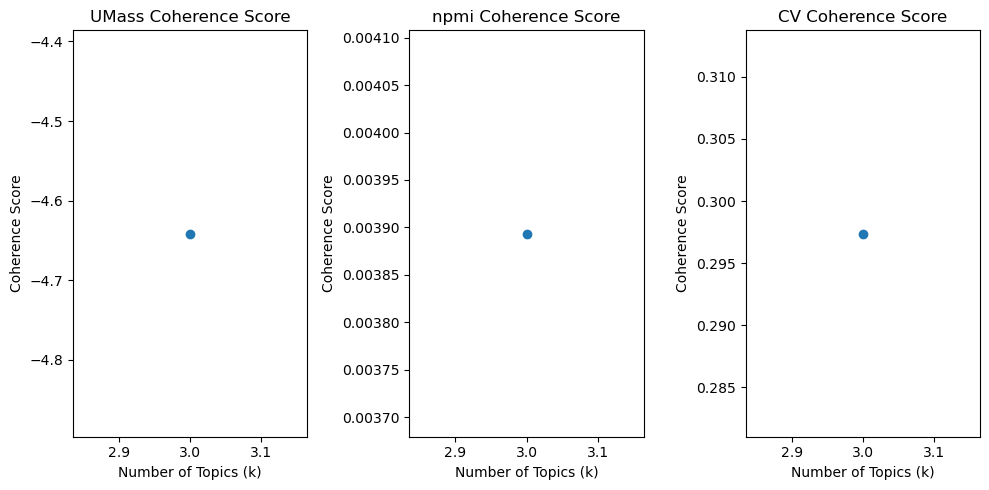

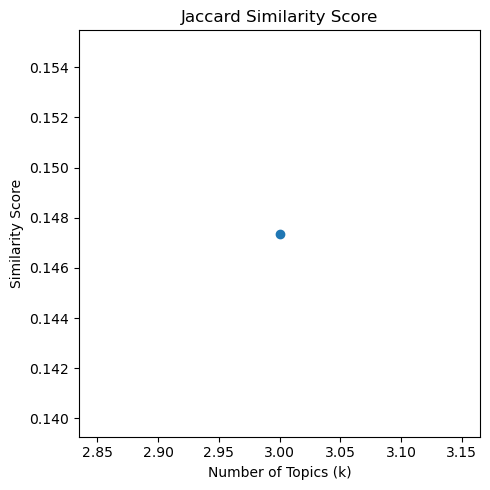

In [27]:
# Plotting UMass Coherence Score
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(range(3, k_max, 2), umass_results, marker='o')
plt.title('UMass Coherence Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score')

# Plotting npmi Coherence Score
plt.subplot(1, 3, 2)
plt.plot(range(3, k_max, 2), npmi_results, marker='o')
plt.title('npmi Coherence Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score')

# Plotting CV Coherence Score
plt.subplot(1, 3, 3)
plt.plot(range(3, k_max, 2), cv_results, marker='o')
plt.title('CV Coherence Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score')

plt.tight_layout()
plt.show()

# Plotting Jaccard Similarity Score
plt.figure(figsize=(5, 5))
plt.plot(range(3, k_max, 2), jacc_results, marker='o')
plt.title('Jaccard Similarity Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Similarity Score')

plt.tight_layout()
plt.show()


In [28]:
# problem : augmenter le nb de topics revient à overfitter le modele,
# ce qui penalise umass et npmi et favorise c_v (on le voit bien sur les 3 premieres courbes, en haut)
# En revanche les resultats pour la similarté (en bas) sont plus faciles à interpréter.

# Ici entre la méthode du coude sur umass (k=7), npmi (k=7) et cv (k=7)
# + minimum jaccard (k=9),
# je prendrais k=7 ou k=9 comme nombre opti de topics, selon qu'on préfère + ou - précis

# c un nombre raisonnable, qui nous donne les topics les mieux différenciés
# (d'après Jaccard)
# et les + cohérents (autres scores)


## tfidf + nmf


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

def suggest_topics_using_TFIDF_NMF(df, feature, alea=42, query='exemple'):
    documents = df[feature].tolist()

    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

    # NMF
    nmf = NMF(n_components=10, random_state=alea)
    nmf.fit(tfidf_matrix)

    # Access basis matrix (W)
    basis_matrix_W = nmf.transform(tfidf_matrix) # = documents-topics

    # Access coefficients matrix (H)
    coefficients_matrix_H = nmf.components_ # = topics-mots

    # Number of top words to display for each topic
    n_top_words = 10

    # Print top words for each topic
    for topic_idx, topic in enumerate(coefficients_matrix_H):
        top_words_idx = topic.argsort()[:-n_top_words - 1 :-1]
        top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

    return nmf, tfidf_vectorizer, coefficients_matrix_H

# Example usage:
nmf_test, vectorizer_test, topics = suggest_topics_using_TFIDF_NMF(train, 'title')

# bcp + rapide que la lda a entrainer
# (logique)


Topic #1: string, array, convert, object, json, pandas, value, java, dataframe, column
Topic #2: android, studio, visual, gradle, project, build, java, library, support, activity
Topic #3: net, asp, core, mvc, web, api, json, framework, authentication, application
Topic #4: file, directory, read, upload, load, csv, text, download, line, open
Topic #5: using, java, javascript, jquery, selenium, server, files, multiple, data, class
Topic #6: error, failed, module, type, code, getting, install, server, build, function
Topic #7: python, install, selenium, module, script, windows, list, pandas, opencv, pip
Topic #8: use, function, js, class, async, vs, instead, method, await, std
Topic #9: spring, boot, data, jpa, application, security, rest, json, hibernate, request
Topic #10: ios, app, change, image, react, does, set, js, color, text


In [41]:
test = [0, 1, 2, 3, 4, 5]

result = test[:-3 -1 :-1]
result

[5, 4, 3]

In [60]:
# prediction

query = 'exemple of a python javascript problem'
query_vect = vectorizer_test.transform([query])
query_topics = nmf_test.transform(query_vect)
print(query_topics)
print(type(query_topics), '\n')

# Interpret the resulting topic distribution
top_topics_idx = query_topics[0].argsort()[::-1]  # Sort in descending order
top_topics_strength = query_topics[0, top_topics_idx]

# Print or use the top topics and their strengths
for topic_idx, strength in zip(top_topics_idx, top_topics_strength):
    print(f"Topic #{topic_idx + 1}: Strength {strength:.4f}")


[[0.00452875 0.         0.         0.         0.00605451 0.
  0.12417663 0.         0.         0.0020023 ]]
<class 'numpy.ndarray'> 

Topic #7: Strength 0.1242
Topic #5: Strength 0.0061
Topic #1: Strength 0.0045
Topic #10: Strength 0.0020
Topic #9: Strength 0.0000
Topic #8: Strength 0.0000
Topic #6: Strength 0.0000
Topic #4: Strength 0.0000
Topic #3: Strength 0.0000
Topic #2: Strength 0.0000


In [35]:
pprint(topics)


array([[1.72252131e-02, 1.34681502e-03, 2.12085742e-03, ...,
        0.00000000e+00, 0.00000000e+00, 2.88851664e-03],
       [0.00000000e+00, 0.00000000e+00, 2.74801493e-05, ...,
        0.00000000e+00, 1.68518007e-02, 0.00000000e+00],
       [0.00000000e+00, 9.17482868e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.18594352e-03, 0.00000000e+00, ...,
        1.46778706e-02, 0.00000000e+00, 0.00000000e+00],
       [1.27108243e-03, 3.42728307e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])


In [ ]:
topn = 1000

def jaccard_similarity(topic1, topic2):
    set1 = set(topic1)
    set2 = set(topic2)
    return len(set1.intersection(set2)) / len(set1.union(set2))

# Example
topic1 = get_top_words_for_topic(nmf_test, 0, n_top_words=topn)
topn_tokens_topic1 = [token for token, weight in topic1]

print(topic1)
print(len(topic1))
print(topn_tokens_topic1)

topic2 = get_top_words_for_topic(nmf_test, 1, n_top_words=topn)
topn_tokens_topic2 = [token for token, weight in topic2]

print(topic2)
print(len(topic2))
print(topn_tokens_topic2)

print('Jaccard Similarity between Topics 0 and 1:', jaccard_similarity(topn_tokens_topic1, topn_tokens_topic2))

# For an overview of all topics
def average_jaccard_similarity(nmf_model):
    num_topics = nmf_model.n_components
    total_similarity = 0.0
    pair_count = 0

    # Iterate over all pairs of topics
    for i in range(num_topics):
        for j in range(i + 1, num_topics):
            # Get the word distributions for the two topics
            topic1 = get_top_words_for_topic(nmf_model, i, n_top_words=topn)
            topn_tokens_topic1 = [token for token, weight in topic1]
            topic2 = get_top_words_for_topic(nmf_model, j, n_top_words=topn)
            topn_tokens_topic2 = [token for token, weight in topic2]

            # Calculate Jaccard similarity and update total_similarity
            similarity = jaccard_similarity(topn_tokens_topic1, topn_tokens_topic2)
            total_similarity += similarity
            pair_count += 1

    # Calculate the average Jaccard similarity
    average_similarity = total_similarity / pair_count
    return average_similarity

# Example
average_jaccard = average_jaccard_similarity(nmf_test)
print('Average Jaccard Similarity between Topics:', average_jaccard)


## Word2Vec / doc2vec + K-Means ?


In [ ]:
# Pb : le kmeans va definir des topics entierement disjoints,
# chaque document appartiendra" à un cluste/topic.
# c'est interessant, mais pas exactement ce qu'on cherche a faire ds ce projet
# (nous voulons predire plusieurs tags).

# Meme remarque avec les autres algorithmes d'assignation de label unique, comme le
# en plus, on doit tjs attribuer manuellement un nom a chaque topic (cluster) defini par le kmeans.

# un algo de clusterisation hierarchique aurait l'avantage de prendre en compte
# les topics inclus dans d'autres plus generaux. en revanche


## doc2vec


## LSA ? = tfidf + svd
